In [37]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import json
import pandas_profiling as pp
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

In [2]:
data = [json.loads(line) for line in open('downloads/transactions.txt', 'r')]
data_df = pd.DataFrame.from_records(data)
data_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


Question 1: Load
1. Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found here
2. Please describe the structure of the data. Number of records and fields in each record?
3. Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [3]:
data_df.describe(include='all')

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
count,786363,786363,786363.000000,786363.000000,786363,786363.000000,786363,786363,786363,786363,...,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363
unique,5000,5000,NaN,NaN,776637,NaN,2490,5,5,6,...,1,NaN,1,1,1,2,1,1,2,2
top,380680241,380680241,NaN,NaN,2016-05-28T14:24:41,NaN,Uber,US,US,05,...,,NaN,,,,False,,,False,False
freq,32850,32850,NaN,NaN,4,NaN,25613,774709,778511,315035,...,786363,NaN,786363,786363,786363,433495,786363,786363,785320,773946
mean,NaN,NaN,10759.464459,6250.725369,NaN,136.985791,NaN,NaN,NaN,NaN,...,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,11636.174890,8880.783989,NaN,147.725569,NaN,NaN,NaN,NaN,...,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,250.000000,-1005.630000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,5000.000000,1077.420000,NaN,33.650000,NaN,NaN,NaN,NaN,...,NaN,689.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,7500.000000,3184.860000,NaN,87.900000,NaN,NaN,NaN,NaN,...,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,15000.000000,7500.000000,NaN,191.480000,NaN,NaN,NaN,NaN,...,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Question 2: Plot
1. Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
2. Report any structure you find and any hypotheses you have about that structure.

In [4]:
profile = pp.ProfileReport(data_df)

In [5]:
profile

Number of variables,29
Number of observations,786363
Total Missing (%),0.0%
Total size in memory,158.2 MiB
Average record size in memory,211.0 B
Numeric,4
Categorical,16
Boolean,3
Date,0
Text (Unique),0
Rejected,6


Question 3: Data Wrangling - Duplicate Transactions
You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.
1. Can you programmatically identify reversed and multi-swipe transactions?
2. What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
3. Did you find anything interesting about either kind of transaction?

In [26]:
# convert transaction date field to date time type
data_df.loc[:, 'transactionDateTime'] = data_df['transactionDateTime'].apply(pd.to_datetime)

In [6]:
# Create transaction amount lead and lag columns by account number, customer id and merchant name
data_df.loc[:,"transaction_lag"] = (data_df.sort_values(by=['transactionDateTime'], ascending=True).groupby(['accountNumber', 'customerId', 'merchantName'])['transactionAmount'].shift(1))
data_df.loc[:,"transaction_lead"] = (data_df.sort_values(by=['transactionDateTime'], ascending=True).groupby(['accountNumber', 'customerId', 'merchantName'])['transactionAmount'].shift(-1))

In [27]:
# Create transaction date time lead and lag columns by account number, customer id and merchant name
data_df.loc[:,"timestamp_lag"] = (data_df.sort_values(by=['transactionDateTime'], ascending=True).groupby(['accountNumber', 'customerId', 'merchantName'])['transactionDateTime'].shift(1))
data_df.loc[:,"timestamp_lead"] = (data_df.sort_values(by=['transactionDateTime'], ascending=True).groupby(['accountNumber', 'customerId', 'merchantName'])['transactionDateTime'].shift(-1))

In [10]:
# Check if the subsequent transaction amounts are matching by account number, customer id and merchant name
data_df.loc[:, 'is_amount_matching'] = np.where((data_df['transactionAmount'] == data_df['transaction_lag']) | (data_df['transactionAmount'] == data_df['transaction_lead']), 1, 0)

In [42]:
# Check time difference between trasaction by same consumer by account number, customer id and merchant name
data_df.loc[:, 'transaction_time_diff'] = (data_df["transactionDateTime"] - data_df["timestamp_lag"]).dt.total_seconds()

In [35]:
data_df.transaction_time_diff.describe()

count    5.774760e+05
mean     2.210786e+06
std      3.827112e+06
min      0.000000e+00
25%      1.378175e+05
50%      7.467080e+05
75%      2.597413e+06
max      3.142817e+07
Name: transaction_time_diff, dtype: float64

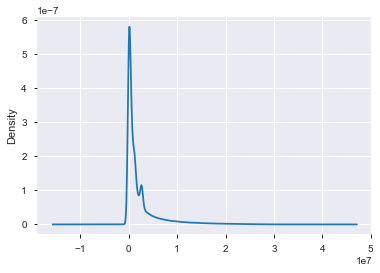

In [38]:
data_df.transaction_time_diff.plot.kde()

In [40]:
print(data_df.transaction_time_diff.quantile(0.1)) # 10th percentile
print(data_df.transaction_time_diff.quantile(0.5)) # 50th percentile
print(data_df.transaction_time_diff.quantile(0.9)) # 90th percentile

15261.000000000002
746708.0
6192235.0


In [47]:
data_df[data_df.transaction_time_diff<=data_df.transaction_time_diff.quantile(0.1)]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transaction_lag,transaction_lead,timestamp_lag,timestamp_lead,is_amount_matching,transaction_time_diff
39,574788567,574788567,2500.0,2200.98,2016-05-24 01:38:03,215.13,Convenient Tire,US,US,09,...,,,False,False,215.13,11.27,2016-05-24 01:35:33,2016-09-24 15:26:31,1,150.0
133,984504651,984504651,50000.0,46367.41,2016-01-16 09:53:15,450.74,Planet Fitness #849960,US,US,05,...,,,False,False,450.74,NaN,2016-01-16 09:52:30,NaT,1,45.0
177,984504651,984504651,50000.0,39749.00,2016-02-03 08:46:00,1007.69,Lyft,US,US,05,...,,,False,False,70.45,36.75,2016-02-03 07:48:00,2016-02-04 03:09:39,0,3480.0
200,984504651,984504651,50000.0,36452.49,2016-02-12 05:10:49,34.92,Golds Gym #747443,US,US,09,...,,,False,False,34.92,149.25,2016-02-12 05:08:23,2016-06-09 18:31:46,1,146.0
263,984504651,984504651,50000.0,26680.99,2016-03-12 06:34:29,118.52,AMC #706324,US,US,02,...,,,False,False,118.52,118.52,2016-03-12 06:34:13,2016-03-12 06:36:41,1,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786014,205026043,205026043,5000.0,1571.26,2016-09-18 06:08:02,56.26,Lyft,US,US,05,...,,,False,False,56.26,321.38,2016-09-18 06:07:17,2016-09-18 08:45:55,1,45.0
786015,205026043,205026043,5000.0,1627.52,2016-09-18 08:45:55,321.38,Lyft,US,US,02,...,,,False,False,56.26,0.42,2016-09-18 06:08:02,2016-09-27 21:01:03,0,9473.0
786024,205026043,205026043,5000.0,692.68,2016-11-02 22:44:38,67.48,Arbys #384282,US,US,09,...,,,False,False,158.70,NaN,2016-11-02 22:43:57,NaT,0,41.0
786120,638498773,638498773,10000.0,9798.21,2016-01-01 19:48:03,201.79,KFC #928167,US,US,05,...,,,False,False,201.79,NaN,2016-01-01 19:45:47,NaT,1,136.0


In [46]:
os.getcwd()

'/Users/regukook'

In [ ]:

# 11.9

df.field_A.quantile(0.5) # same as median
# 62.0

df.field_A.quantile(0.9) # 90th percentile
# 89.10000000000001

In [11]:
data_df.merchantCategoryCode.value_counts()

online_retail           202156
fastfood                112138
entertainment            80098
food                     75490
online_gifts             66238
rideshare                51136
hotels                   34097
fuel                     23910
subscriptions            22901
auto                     21651
health                   19092
personal care            18964
airline                  15412
mobileapps               14990
online_subscriptions     11067
furniture                 7432
food_delivery             6000
gym                       2209
cable/phone               1382
Name: merchantCategoryCode, dtype: int64

In [12]:
data_df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud',
       'transaction_lag', 'transaction_lead', 'timestamp_lag',
       'timestamp_lead', 'is_amount_matching'],
      dtype='object')

In [13]:
data_df.isFraud.value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

##### # of accounts that have fraudulent transaction

In [14]:
len(data_df.accountNumber[data_df.isFraud == True].unique())

2075

In [15]:
X_df = data_df[['creditLimit', 'transactionAmount']]
Y_df = data_df[['isFraud']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.33, random_state=42)

In [17]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [18]:
y_pred = clf.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99    255460
        True       0.06      0.04      0.05      4040

    accuracy                           0.98    259500
   macro avg       0.52      0.51      0.52    259500
weighted avg       0.97      0.98      0.97    259500

